In [1]:
import os
import pandas as pd
import tensorflow as tf
import keras
import numpy as np

from keras import regularizers
from keras.layers import Flatten
import collections
from sklearn.model_selection import train_test_split
import warnings
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv1D,Dense,Dropout,MaxPooling1D,ZeroPadding1D, Flatten,BatchNormalization,Lambda

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import doc2vec

import matplotlib.pyplot as plt

In [2]:
# Doc2Vec 모델 불러오기
p2v_model = doc2vec.Doc2Vec.load('p2v_128_all_1.model')
# 데이터 불러오기
data=pd.read_csv('all_after_filter.csv')
person_id=data['PERSON_ID'].unique()
data.sort_values('RECU_FR_DT',inplace=True)
data.drop(columns=['KEY_SEQ','RECU_FR_DT','MAIN_ICDnorm'],inplace=True)
person_id=person_id.tolist()
train_label_df=pd.read_csv('label_train1.csv')
test_label_df=pd.read_csv('label_test1.csv')
train_label_df.iloc[:,2]=train_label_df.iloc[:,2].astype('float32')
test_label_df.iloc[:,2]=test_label_df.iloc[:,2].astype('float32')
person_doc_dict={key:value for value,key in enumerate(person_id)}

In [ ]:
# 각 visit embedding 후 metrics만들기
embedding=np.zeros(shape=[len(person_id),480,128],dtype='float32')
def get_vec(person_id,train_df):
    person2vec=np.zeros(shape=[480,128])
    features=['SEX','AGE_GROUP','CLA_ITE','GNL_NM_CD','SICK_SYMnorm']
    this_person_record=train_df[train_df.PERSON_ID==person_id]
    for index,record in enumerate(this_person_record[features].iterrows()):
        thisrec=','.join('%s' %con for con in record[1].tolist())
        thisvec=p2v_model.infer_vector(thisrec.split(','))
        person2vec[index]=thisvec
        person2vec.astype('float32')
    return person2vec

for i,thisperson in enumerate(person_id):
    embedding[i]=get_vec(thisperson,train_df=data)
np.save('embedding_metrix_1',embedding)

In [4]:
embedding=np.load('embedding_metrix_1.npy')

In [5]:
# train에서 검증셋 추출
from sklearn.model_selection import train_test_split
new_train_label_df, cv_label_df =train_test_split(train_label_df, test_size=0.25, random_state=3)

In [6]:
new_train_label_df.shape ,cv_label_df.shape, test_label_df.shape

((120000, 3), (40000, 3), (40000, 3))

In [7]:
# similarity learning을 진행하기 위한 데이터 셋 만들기
class CSV_dataset():
    def __init__(self, label_df, person_doc_dict, embedding):
        super(CSV_dataset, self).__init__()
        self.label_df = label_df
        self.person_doc_dict = person_doc_dict
        self.embedding = embedding
    def __getitem__(self, item):
        person_1 = self.label_df.iloc[item, 0]
        person_2 = self.label_df.iloc[item, 1]
        person_1_id=self.person_doc_dict[person_1]
        person_2_id=self.person_doc_dict[person_2]
        person_1_vec =self.embedding[person_1_id]
        person_2_vec =self.embedding[person_2_id]
        similarity = self.label_df.iloc[item, 2]
        
        return person_1_vec, person_2_vec, similarity
    def __len__(self):
        return len(self.label_df)

In [8]:
train_ds = CSV_dataset(new_train_label_df, person_doc_dict, embedding)
train_data_left =[]
train_data_right = []
train_label = []

for i in range(10000):
    r = train_ds.__getitem__(i)
    train_data_left.append(r[0])
    train_data_right.append(r[1])
    train_label.append([r[2]])
    
train_data_left = np.array(train_data_left)
train_data_right = np.array(train_data_right)
train_label = np.array(train_label)                 

In [9]:
cv_ds = CSV_dataset(cv_label_df, person_doc_dict, embedding)
cv_data_left =[]
cv_data_right = []
cv_label = []


for i in range(2000):
    r = cv_ds.__getitem__(i)
    cv_data_left.append(r[0])
    cv_data_right.append(r[1])
    cv_label.append([r[2]])

cv_data_left = np.array(cv_data_left)
cv_data_right = np.array(cv_data_right)
cv_label = np.array(cv_label)

In [10]:
test_ds = CSV_dataset(test_label_df, person_doc_dict, embedding)
test_data_left =[]
test_data_right = []
test_label = []

for i in range(2000):
    r = test_ds.__getitem__(i)
    test_data_left.append(r[0])
    test_data_right.append(r[1])
    test_label.append([r[2]])


test_data_left = np.array(test_data_left)
test_data_right = np.array(test_data_right)
test_label = np.array(test_label)  

In [11]:
# 두 vactor 사이에 L2 거리구하기
def euclidean_distance(vectors):
    # unpack the vectors into separate lists
    (featsA, featsB) = vectors
    # compute the sum of squared distances between the vectors
    sumSquared = K.sum(K.square(featsA - featsB), axis=1,
        keepdims=True)
    # return the euclidean distance between the vectors
    return K.sqrt(K.maximum(sumSquared, K.epsilon()))

# 샴네트워크

In [12]:
# specify the shape of the inputs for our network
IMG_SHAPE = (480, 128)
# specify the batch size and number of epochs
BATCH_SIZE = 64
EPOCHS = 100
# define the path to the base output directory
BASE_OUTPUT = "output"

MODEL_PATH = os.path.sep.join([BASE_OUTPUT,
	"contrastive_siamese_model"])
PLOT_PATH = os.path.sep.join([BASE_OUTPUT,
	"contrastive_plot.png"])

In [13]:
# 그림 그리기
def plot_training(H, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [15]:
# 두 환자의 representation vector를 얻기위한 model 생성
def build_siamese_model(inputShape):
    inputs = Input(inputShape)
    x = Conv1D(64, 10, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 7, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(64, 5, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 10, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D( )(x)
    x = Dropout(0.3)(x)
    

    x = Conv1D(128, 7, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 5, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)
    
    x = Conv1D(128, 5, padding="same", activation="relu",kernel_regularizer = regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D()(x)
    x = Dropout(0.3)(x)

    
    outputs = Flatten()(x)
    model = Model(inputs, outputs)
    return model

In [16]:
# loss fuction 만들기
def contrastive_loss(y, preds, margin=1):
    y = tf.cast(y, preds.dtype)
    squaredPreds = K.square(preds)
    squaredMargin = K.square(K.maximum(margin - preds, 0))
    loss = K.mean(y * squaredPreds + (1 - y) * squaredMargin)
    return loss

In [21]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
# Feature vector 만들기
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# 두 feature vector간 거리구하기
distance = Lambda(euclidean_distance)([featsA,featsB])
model = Model(inputs=[imgA, imgB], outputs=distance)

[INFO] compiling model...
[INFO] training model...
Epoch 1/100
313/313 [==============================] - 118s 356ms/step - loss: 1634.8546 - val_loss: 24.4098
Epoch 2/100
313/313 [==============================] - 100s 318ms/step - loss: 529.1856 - val_loss: 3.3309
Epoch 3/100
313/313 [==============================] - 100s 319ms/step - loss: 290.0895 - val_loss: 2.1554
Epoch 4/100
313/313 [==============================] - 98s 313ms/step - loss: 147.9224 - val_loss: 1.5445
Epoch 5/100
313/313 [==============================] - 98s 312ms/step - loss: 69.1329 - val_loss: 1.0436
Epoch 6/100
313/313 [==============================] - 98s 314ms/step - loss: 28.4749 - val_loss: 0.9236
Epoch 7/100
313/313 [==============================] - 99s 315ms/step - loss: 10.1725 - val_loss: 0.9350
Epoch 8/100
313/313 [==============================] - 98s 312ms/step - loss: 3.2902 - val_loss: 1.0026
Epoch 9/100
313/313 [==============================] - 98s 312ms/step - loss: 1.2150 - val_loss: 1.04

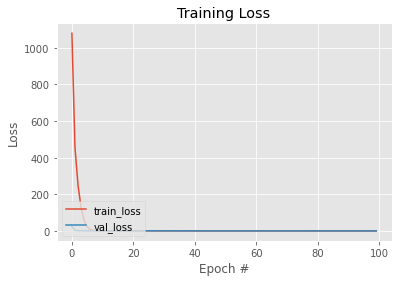

In [32]:
print("[INFO] compiling model...")
opt = keras.optimizers.Adam(learning_rate = 0.001)
model.compile(loss=contrastive_loss, optimizer=opt)
# model train
print("[INFO] training model...")
history = model.fit(
    [train_data_left, train_data_right ], train_label[:],
    validation_data=([cv_data_left, cv_data_right], cv_label[:]),
    batch_size=32,
    epochs=100)
# 그래프 그리기
print("[INFO] plotting training history...")
plot_training(history, PLOT_PATH)
# weights 저장
model.save_weights('sam_model.h5')